In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/StudyData/Sochi_weather_19102020_15102011.csv')
df.head()

,LocalTime,T,Po,P,Pa,U,DD
0,19.10.2020 09:00,19.9,761.2,762.5,0.0,69.0,NaN
1,19.10.2020 06:00,18.6,761.2,762.5,0.0,83.0,NaN
2,19.10.2020 03:00,20.2,761.2,762.5,1.2,87.0,NaN
3,19.10.2020 00:00,19.0,760.0,761.3,-0.3,68.0,NaN
4,18.10.2020 21:00,18.2,760.3,761.6,0.6,82.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26308 entries, 0 to 26307
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LocalTime  26308 non-null  object 
 1   T          26265 non-null  float64
 2   Po         26283 non-null  float64
 3   P          26264 non-null  float64
 4   Pa         22474 non-null  float64
 5   U          26224 non-null  float64
 6   DD         0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 1.4+ MB


In [5]:
df = df.drop('DD', axis=1)

In [6]:
df.isna().sum()

LocalTime       0
T              43
Po             25
P              44
Pa           3834
U              84
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22389 entries, 0 to 22690
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LocalTime  22389 non-null  object 
 1   T          22389 non-null  float64
 2   Po         22389 non-null  float64
 3   P          22389 non-null  float64
 4   Pa         22389 non-null  float64
 5   U          22389 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


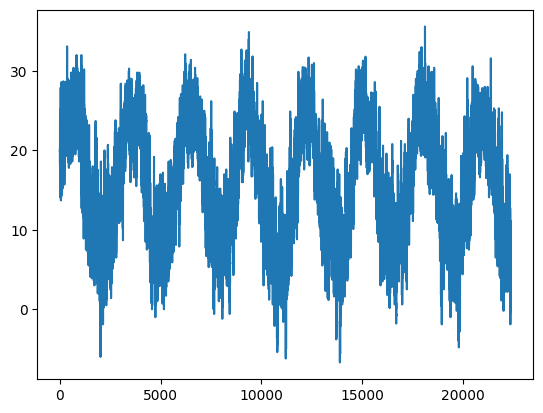

In [13]:
plt.plot(range(1,len(df['T'].values)+1),df['T'].values)

In [14]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data = df['T'].values
data = min_max_scaler.fit_transform(data.reshape(-1, 1))

In [15]:
print(data.shape)
data =data.flatten()
print(data.shape)

(22389, 1)
(22389,)


In [16]:
window = 20

n_samples=data.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.15*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  15658 Validation =  3355 Test =  3356


In [17]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [18]:
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=data[i+j]
  y_train[i]=data[i+window]

for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=data[n_train_samples+i+j]
  y_val[i]=data[n_train_samples+i+window]

for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=data[n_train_samples+n_val_samples+i+j]
  y_test[i]=data[n_train_samples+n_val_samples+i+window]

In [19]:
from keras.models import Sequential
from keras.layers import Dense

ff_model=Sequential()
ff_model.add(Dense(12,activation='relu',input_dim=window))
ff_model.add(Dense(1))

In [20]:
ff_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                252       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


In [21]:
ff_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [124]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/StudyData/Models/ff-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [125]:
ff_model_history = ff_model.fit(X_train,y_train,batch_size=25,epochs=60,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/60
625/627 [============================>.] - ETA: 0s - loss: 0.0394 - mae: 0.1217
Epoch 1: val_mae improved from inf to 0.05299, saving model to /content/gdrive/MyDrive/StudyData/Models/ff-temperature-01-0.053.hdf5
627/627 [==============================] - 2s 2ms/step - loss: 0.0393 - mae: 0.1216 - val_loss: 0.0048 - val_mae: 0.0530
Epoch 2/60
599/627 [===========================>..] - ETA: 0s - loss: 0.0036 - mae: 0.0455
Epoch 2: val_mae improved from 0.05299 to 0.04185, saving model to /content/gdrive/MyDrive/StudyData/Models/ff-temperature-02-0.042.hdf5
627/627 [==============================] - 1s 2ms/step - loss: 0.0036 - mae: 0.0454 - val_loss: 0.0031 - val_mae: 0.0418
Epoch 3/60
599/627 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0387
Epoch 3: val_mae improved from 0.04185 to 0.03720, saving model to /content/gdrive/MyDrive/StudyData/Models/ff-temperature-03-0.037.hdf5
627/627 [==============================] - 1s 2ms/step - loss: 0.0026 - mae: 0

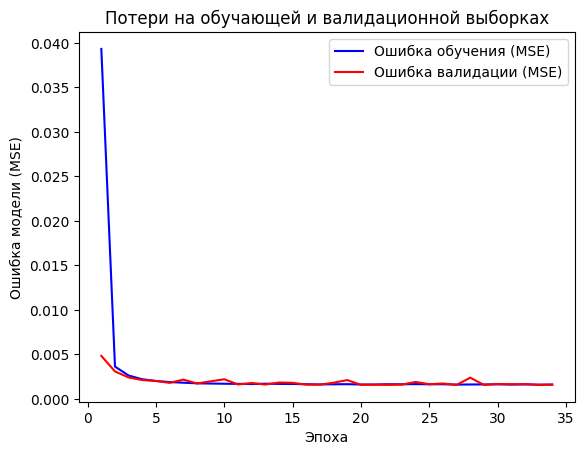

In [126]:
loss_function = ff_model_history.history['loss']
val_loss_function = ff_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MSE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MSE)')
plt.legend()
plt.show()

In [22]:
ff_model.load_weights('/content/gdrive/My Drive/StudyData/Models/ff-temperature-29-0.028.hdf5')

In [23]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error

y_pred = ff_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' C degrees')
print('MSE =', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), 'C^2 degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

105/105 [==============================] - 0s 2ms/step
MAE =  1.243  C degrees
MSE = 3.15 C^2 degrees
R2-score =  0.939


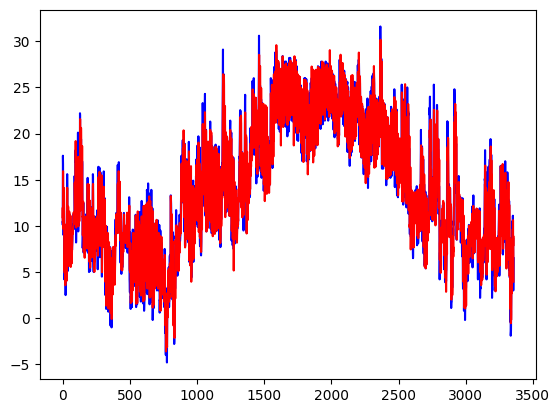

In [28]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv, color='blue', label='Actual')
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv, color='red', label='Predicted')

In [29]:
from keras.layers import SimpleRNN

simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(12,activation='relu',input_shape=(window,1)))
simple_rnn_model.add(Dense(1,activation='linear'))

In [30]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [31]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [134]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/StudyData/Models/simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [135]:
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=25,epochs=60,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/60
627/627 [==============================] - ETA: 0s - loss: 0.0140 - mae: 0.0608
Epoch 1: val_mae improved from inf to 0.03493, saving model to /content/gdrive/MyDrive/StudyData/Models/simple_rnn-temperature-01-0.035.hdf5
627/627 [==============================] - 5s 6ms/step - loss: 0.0140 - mae: 0.0608 - val_loss: 0.0022 - val_mae: 0.0349
Epoch 2/60
624/627 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0338
Epoch 2: val_mae improved from 0.03493 to 0.03269, saving model to /content/gdrive/MyDrive/StudyData/Models/simple_rnn-temperature-02-0.033.hdf5
627/627 [==============================] - 4s 6ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 0.0020 - val_mae: 0.0327
Epoch 3/60
619/627 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0324
Epoch 3: val_mae improved from 0.03269 to 0.03160, saving model to /content/gdrive/MyDrive/StudyData/Models/simple_rnn-temperature-03-0.032.hdf5
627/627 [==============================] - 4s 7ms/step

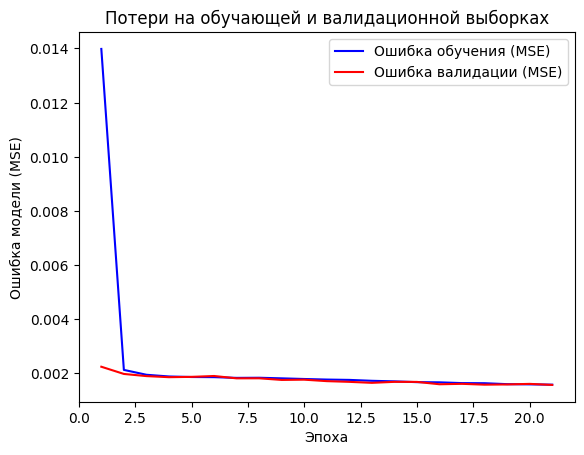

In [136]:
loss_function = simple_rnn_model_history.history['loss']
val_loss_function = simple_rnn_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MSE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MSE)')
plt.legend()
plt.show()

In [32]:
simple_rnn_model.load_weights('/content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-16-0.028.hdf5')

In [33]:
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' C degrees')
print('MSE =', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), 'C^2 degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

105/105 [==============================] - 1s 3ms/step
MAE =  1.293  C degrees
MSE = 3.371 C^2 degrees
R2-score =  0.935


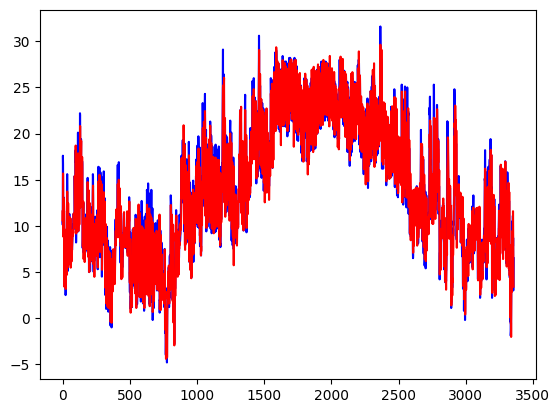

In [34]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv, color='blue', label='Actual')
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv, color='red', label='Predicted')

In [35]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(16,input_shape=(window,1)))
lstm_model.add(Dense(1,activation='linear'))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [142]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/StudyData/Models/lstm-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [36]:
lstm_model.compile(optimizer='adam',loss='mse',metrics='mae')

In [144]:
lstm_model_history = lstm_model.fit(X_train,y_train,epochs=60,batch_size=30,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/60
521/522 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0655
Epoch 1: val_mae improved from inf to 0.05620, saving model to /content/gdrive/MyDrive/StudyData/Models/lstm-temperature-01-0.056.hdf5
522/522 [==============================] - 9s 13ms/step - loss: 0.0075 - mae: 0.0655 - val_loss: 0.0049 - val_mae: 0.0562
Epoch 2/60
520/522 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0568
Epoch 2: val_mae improved from 0.05620 to 0.05388, saving model to /content/gdrive/MyDrive/StudyData/Models/lstm-temperature-02-0.054.hdf5
522/522 [==============================] - 6s 11ms/step - loss: 0.0050 - mae: 0.0568 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 3/60
519/522 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0552
Epoch 3: val_mae improved from 0.05388 to 0.05186, saving model to /content/gdrive/MyDrive/StudyData/Models/lstm-temperature-03-0.052.hdf5
522/522 [==============================] - 5s 10ms/step - loss: 0.0047

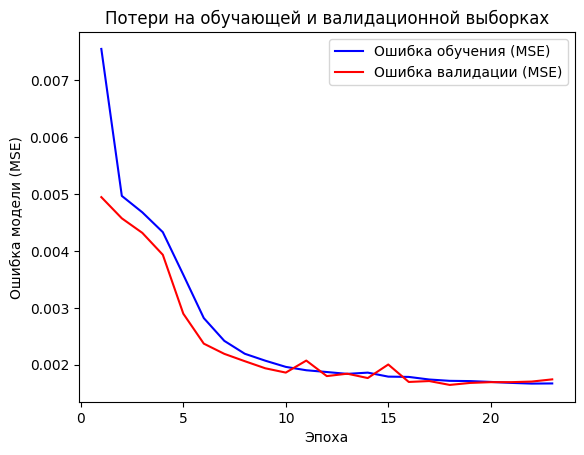

In [145]:
loss_function = lstm_model_history.history['loss']
val_loss_function = lstm_model_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MSE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MSE)')
plt.legend()
plt.show()

In [37]:
lstm_model.load_weights('/content/gdrive/My Drive/StudyData/Models/lstm-temperature-18-0.029.hdf5')

In [38]:
y_pred = lstm_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

105/105 [==============================] - 1s 3ms/step


In [39]:
y_pred = lstm_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import r2_score,mean_absolute_error

print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv, y_pred=y_pred_inv),3), ' C degrees')
print('MSE =', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3), 'C^2 degrees')
print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))

105/105 [==============================] - 1s 5ms/step
MAE (Test) =  1.293  C degrees
MSE = 3.31 C^2 degrees
R2 Score (Test) =  0.936


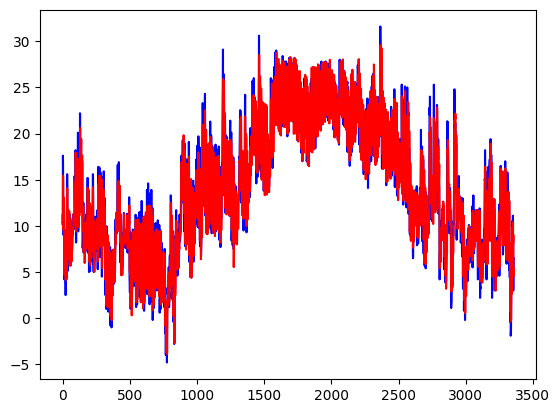

In [40]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv, color='blue', label='Actual')
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv, color='red', label='Predicted')